# Growth Mechanism with Details

In [101]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../src')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, process_rheed_data 
from m3_learning.RHEED.Packed_functions import decay_curve_examples
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, analyze_txt_rheed, select_range

plot_size = (6, 2)
color_blue = (44/255,123/255,182/255)
color_gray = (128/255, 128/255, 128/255, 0.5)
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = (*colors.hex2color(seq_colors[0]), 0.3), (*colors.hex2color(seq_colors[5]), 0.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Visualize the spots from collected data

In [220]:
para_path = 'F:/UMich/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(spot_ds_path, camera_freq=2000, sample_name='J14')
ds_para.data_info

Growth: temp250:
--spot: spot_1:
----height:, Size of data: (499922,)
----img_max:, Size of data: (499922,)
----img_mean:, Size of data: (499922,)
----img_rec_max:, Size of data: (499922,)
----img_rec_mean:, Size of data: (499922,)
----img_rec_sum:, Size of data: (499922,)
----img_sum:, Size of data: (499922,)
----raw_image:, Size of data: (499922, 22, 10)
----reconstructed_image:, Size of data: (499922, 22, 10)
----width_x:, Size of data: (499922,)
----width_y:, Size of data: (499922,)
----x:, Size of data: (499922,)
----y:, Size of data: (499922,)
--spot: spot_2:
----height:, Size of data: (499922,)
----img_max:, Size of data: (499922,)
----img_mean:, Size of data: (499922,)
----img_rec_max:, Size of data: (499922,)
----img_rec_mean:, Size of data: (499922,)
----img_rec_sum:, Size of data: (499922,)
----img_sum:, Size of data: (499922,)
----raw_image:, Size of data: (499922, 29, 13)
----reconstructed_image:, Size of data: (499922, 29, 13)
----width_x:, Size of data: (499922,)
----wid

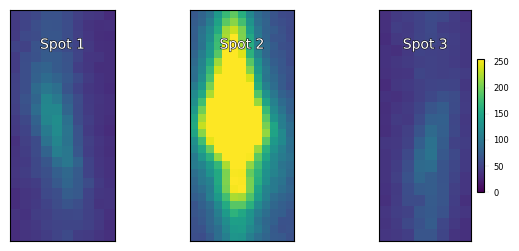

In [10]:
img_spot1 = ds_para.growth_dataset(growth='temp250', metric='raw_image', spot='spot_1', index=100)
img_spot2 = ds_para.growth_dataset(growth='temp250', metric='raw_image', spot='spot_2', index=100)
img_spot3 = ds_para.growth_dataset(growth='temp250', metric='raw_image', spot='spot_3', index=100)

imgs = [img_spot1, img_spot2, img_spot3]
width_ratios = [img.shape[1]/img.shape[0] for img in imgs]
titles = ['Spot 1', 'Spot 2', 'Spot 3']
fig = plt.figure(figsize=(6.5, 3))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=width_ratios, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(len(imgs))]
for i, ax in enumerate(axes):
    if i == 2:
        imagemap(ax, imgs[i], colorbars=True, clim=(0,255), divider_=False)
    else:
        imagemap(ax, imgs[i], colorbars=False, clim=(0,255), divider_=False)
    labelfigs(ax, None, string_add=titles[i], loc='ct', size=10)
plt.show()

## 2. Analyze the Decay Curve

### 2.1 J14-300C

img_sum-spot_1


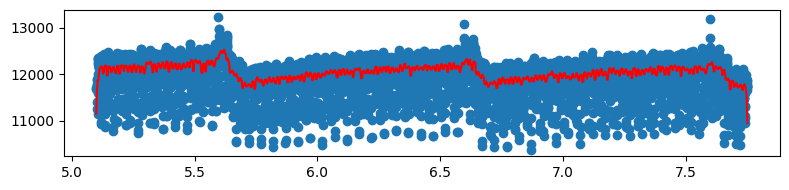

img_rec_sum-spot_1


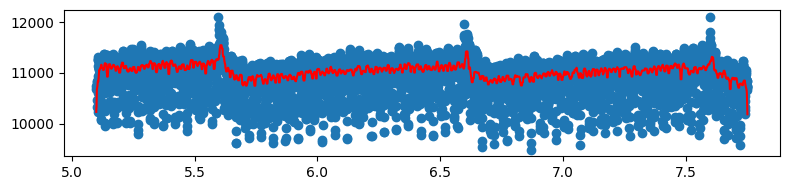

img_sum-spot_2


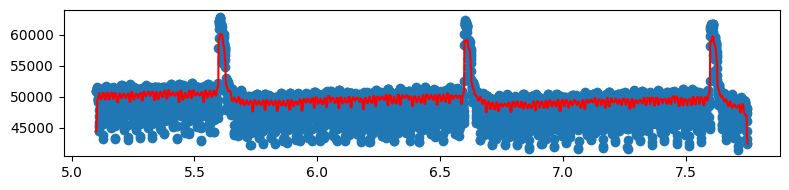

img_rec_sum-spot_2


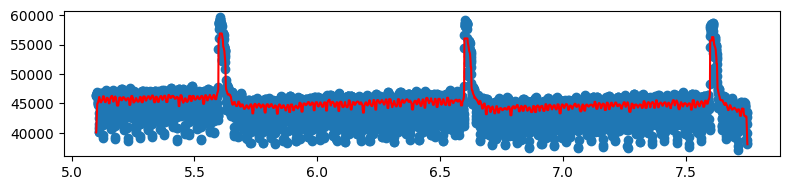

In [205]:
for spot in ['spot_1', 'spot_2']:
#     for m in ["img_mean", "img_sum", "img_max", "img_rec_sum", "img_rec_max", "img_rec_mean", 
#           "height", "x", "y", "width_x", "width_y"]:
    for m in ["img_sum", "img_rec_sum"]:
        x, y = ds_para.load_curve(growth='temp250', spot=spot, metric=m, x_start=0)
        sample_x, sample_y = x[10200:15500], y[10200:15500]
        print(m+'-'+spot)
        
#         plt.figure(figsize=(8,2))
#         plt.scatter(sample_x, sample_y)
#         plt.title(m+'-'+spot)
#         plt.show()
        
#         denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
        denoised_sample_y = denoise_median(sample_x, sample_y, kernel_size=51)

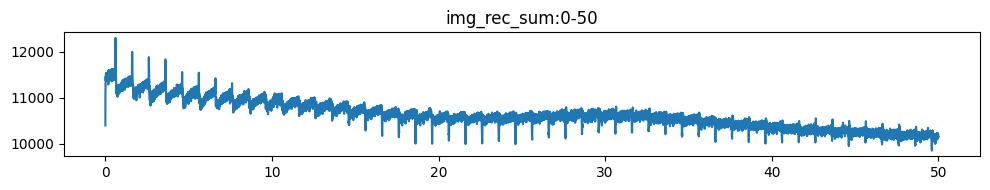

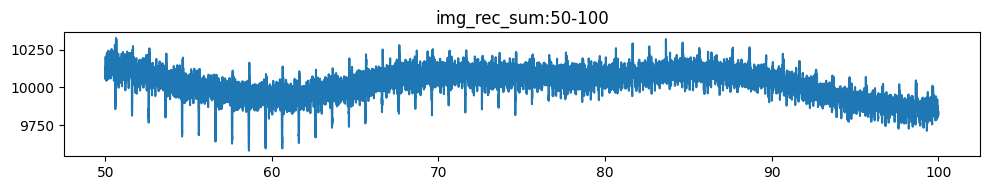

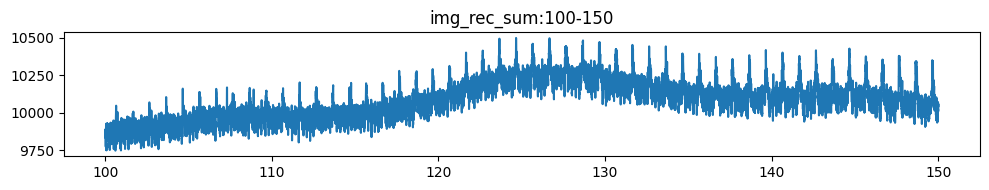

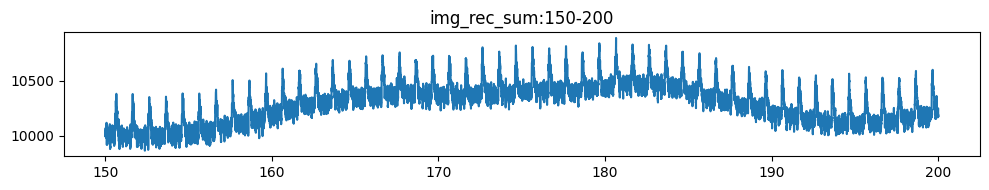

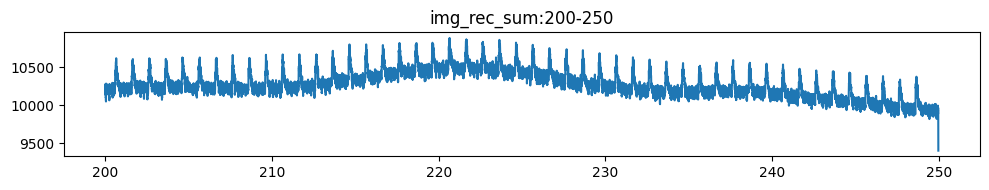

In [165]:
for start in range(0, int(np.max(sample_x))+1, 50):

    data = np.stack([sample_x, denoised_sample_y], 1)
    data = select_range(data, start, start+50)

    x_part, y_part = data[:,0], data[:,1]
    plt.figure(figsize=(10,2))
    plt.plot(x_part, y_part)
    plt.title('img_rec_sum' + ':' + str(start) + '-' + str(start+50))
    plt.tight_layout()
    plt.show()

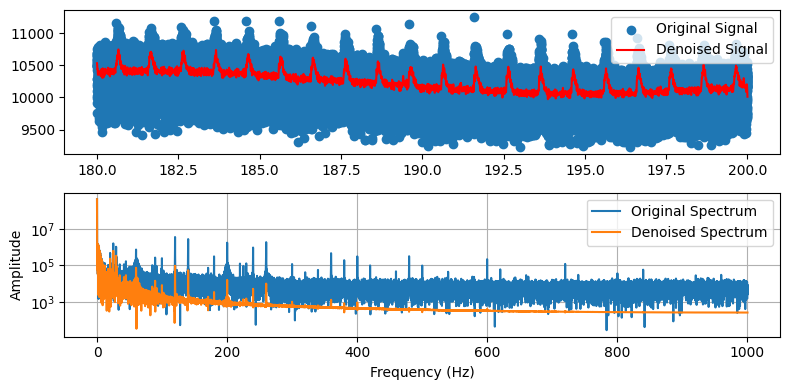

I:\RHEED_data\m3_learning\m3_learning\papers\2023_RHEED_PLD_SrTiO3 - UMich\../../src\m3_learning\RHEED\Viz.py:444: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=-0.5, w_pad=-1, h_pad=-0.5)


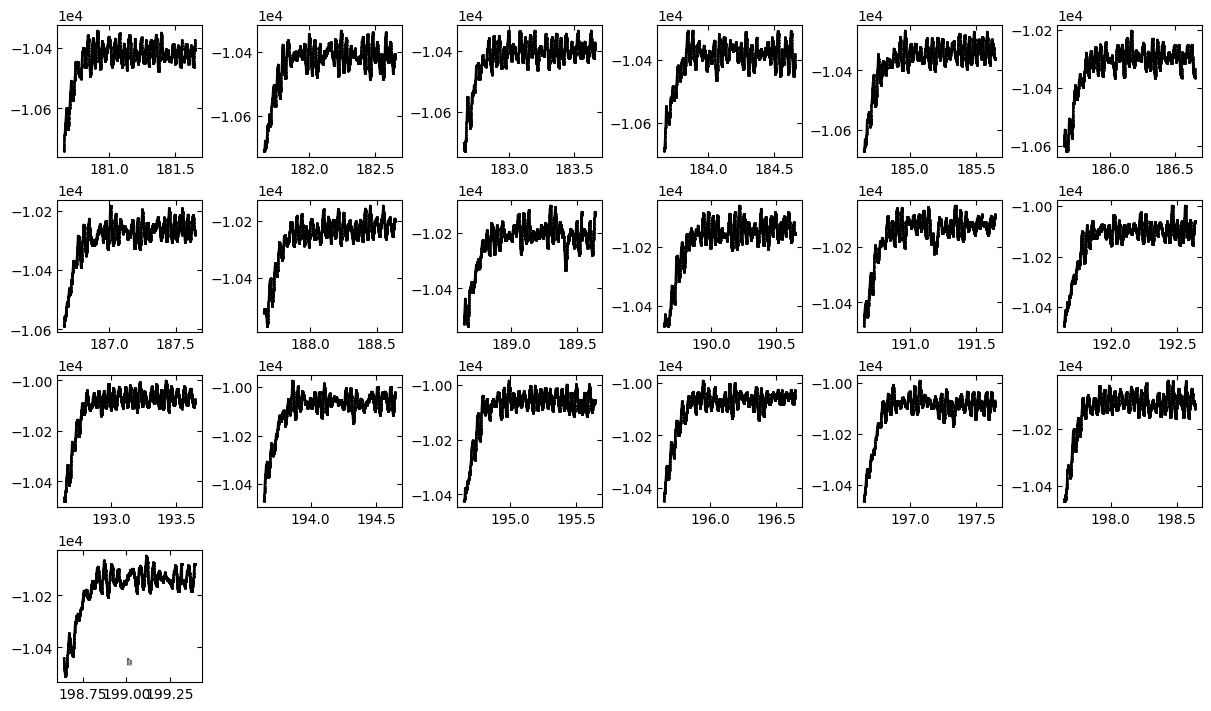

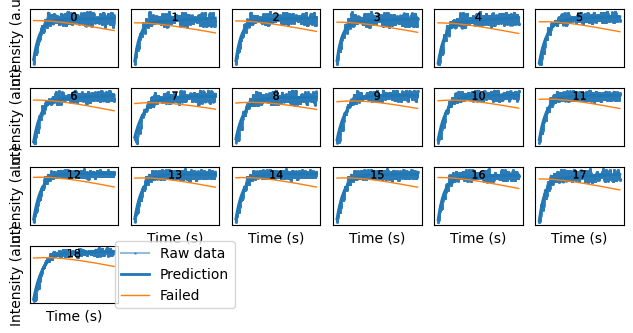

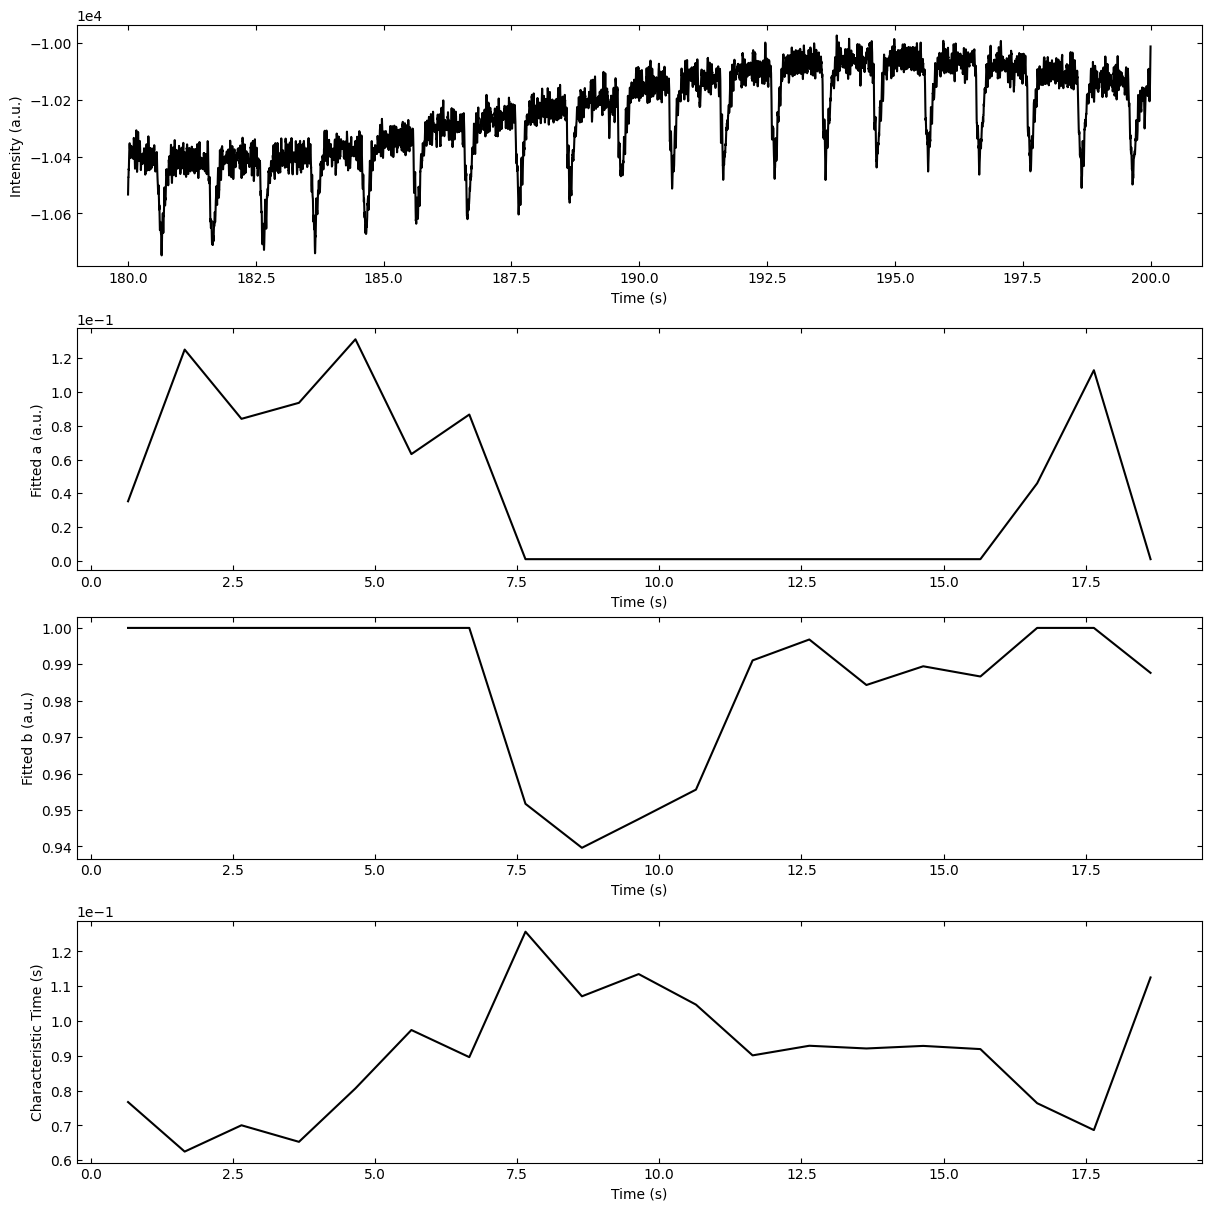

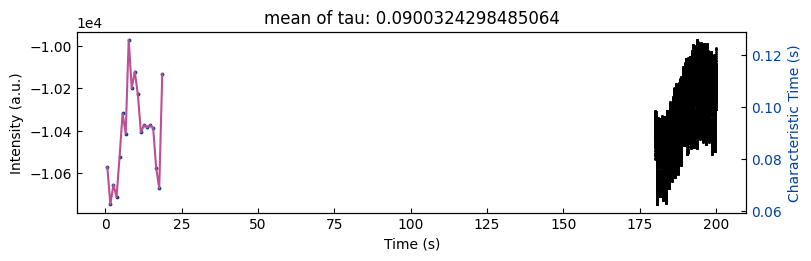

In [269]:
fit_settings={'step_size':101, 'prominence':10, 'savgol_window_order': (15, 3), 'pca_component': 3, 
              'I_diff': None, 'unify':False, 'bounds':[0.001, 1], 'p_init':[0.5, 0.4, 0.1]}
laser_freq = 1
camera_freq = 2000
viz_curves=True
viz_fittings=True
viz_ab=True

data = np.stack([sample_x, sample_y], 1)
data = select_range(data, 180, 200)
part_x, part_y = data[:,0], data[:,1]

denoised_part_y = denoise_fft(part_x, part_y, cutoff_freq=20, denoise_order=1, sample_frequency=2000)
# denoised_part_y = denoise_median(part_x, part_y, kernel_size=51)

data = np.stack([part_x, -denoised_part_y], 1)

parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, fit_settings, 
                                                           viz_curves, viz_fittings, viz_ab, n_std=3)

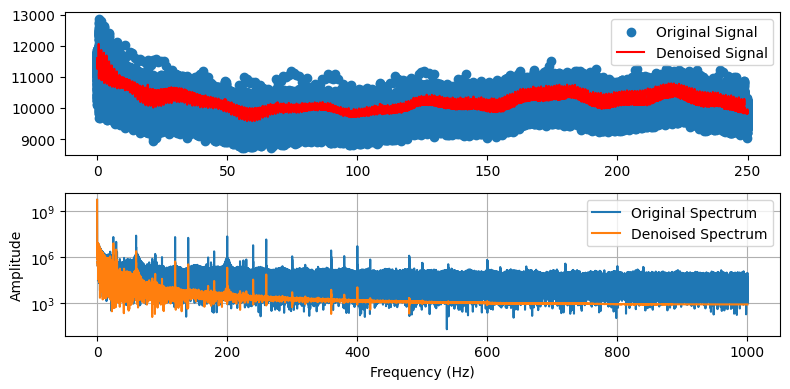

I:\RHEED_data\m3_learning\m3_learning\papers\2023_RHEED_PLD_SrTiO3 - UMich\../../src\m3_learning\RHEED\Viz.py:414: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=-0.5, w_pad=-1, h_pad=-0.5)


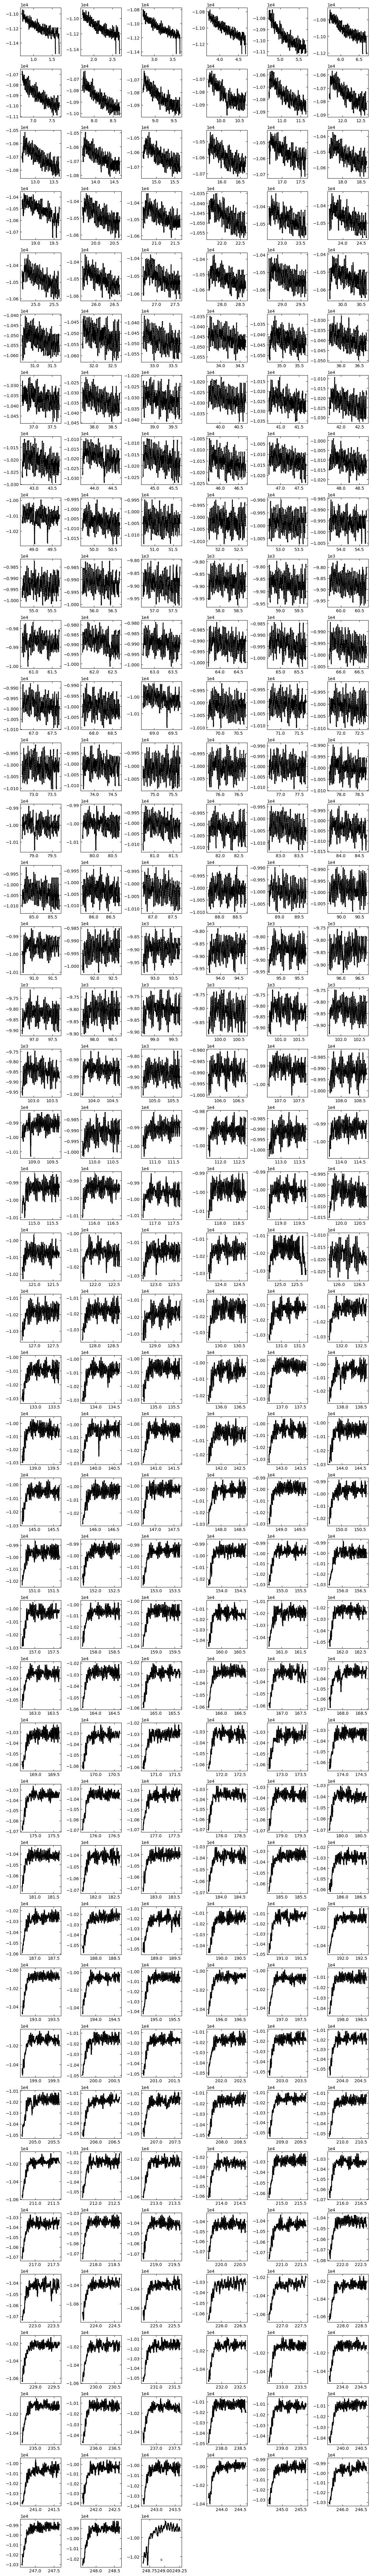

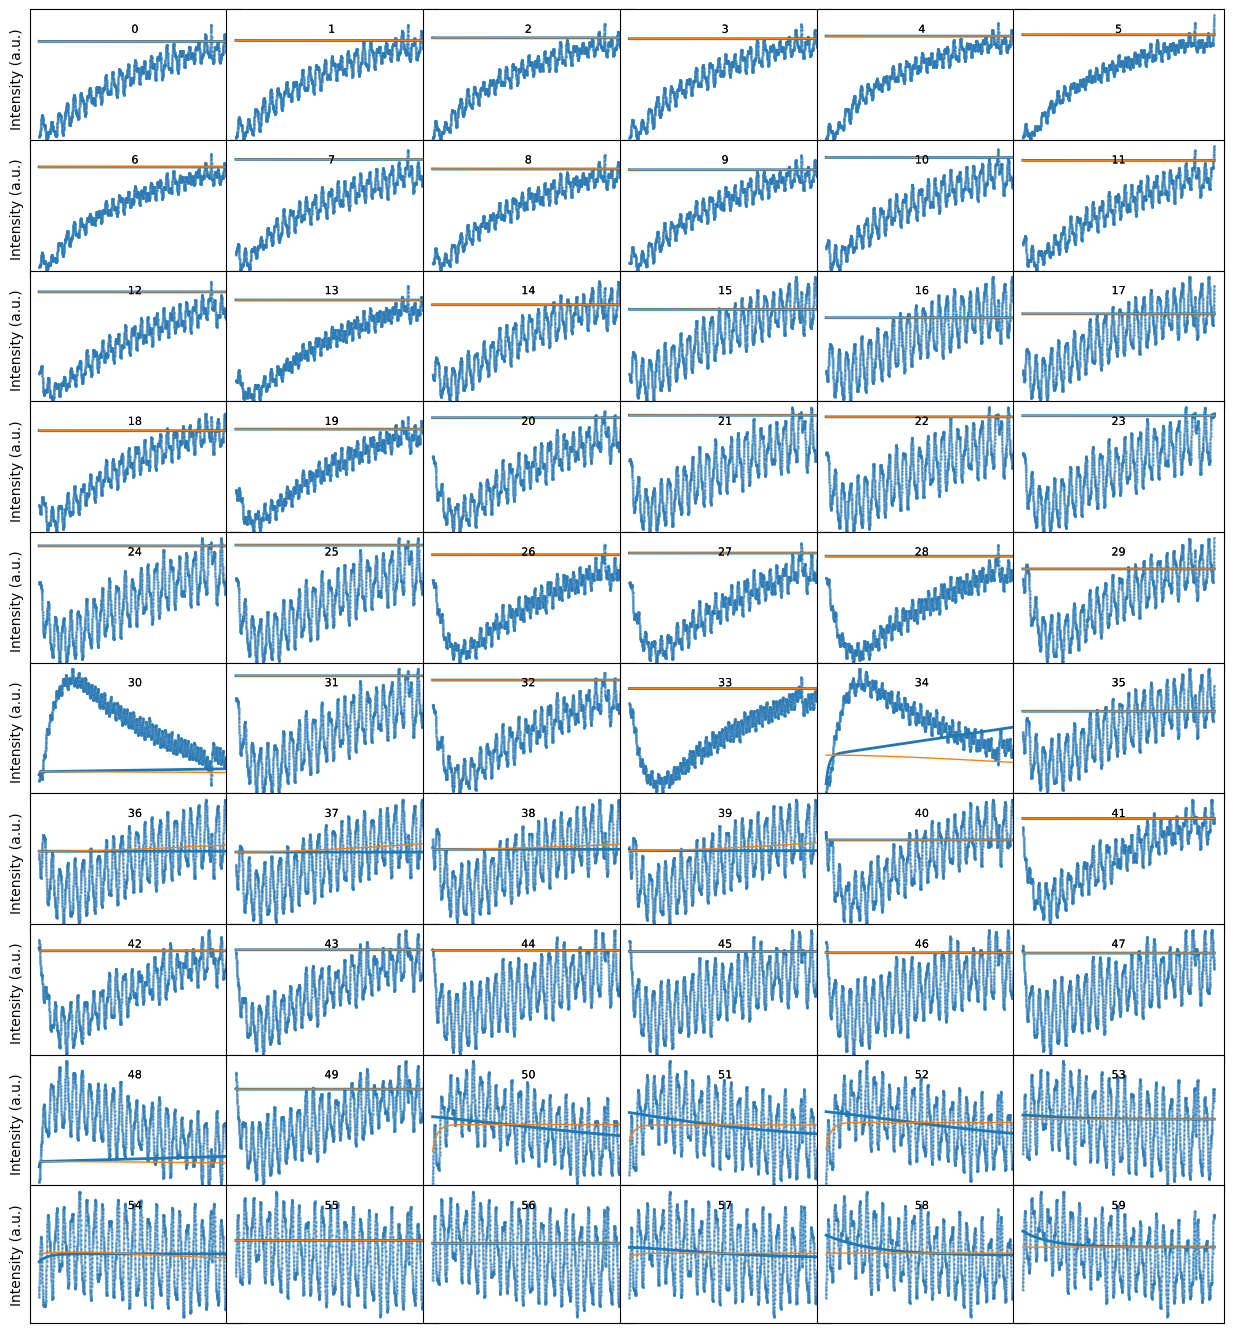

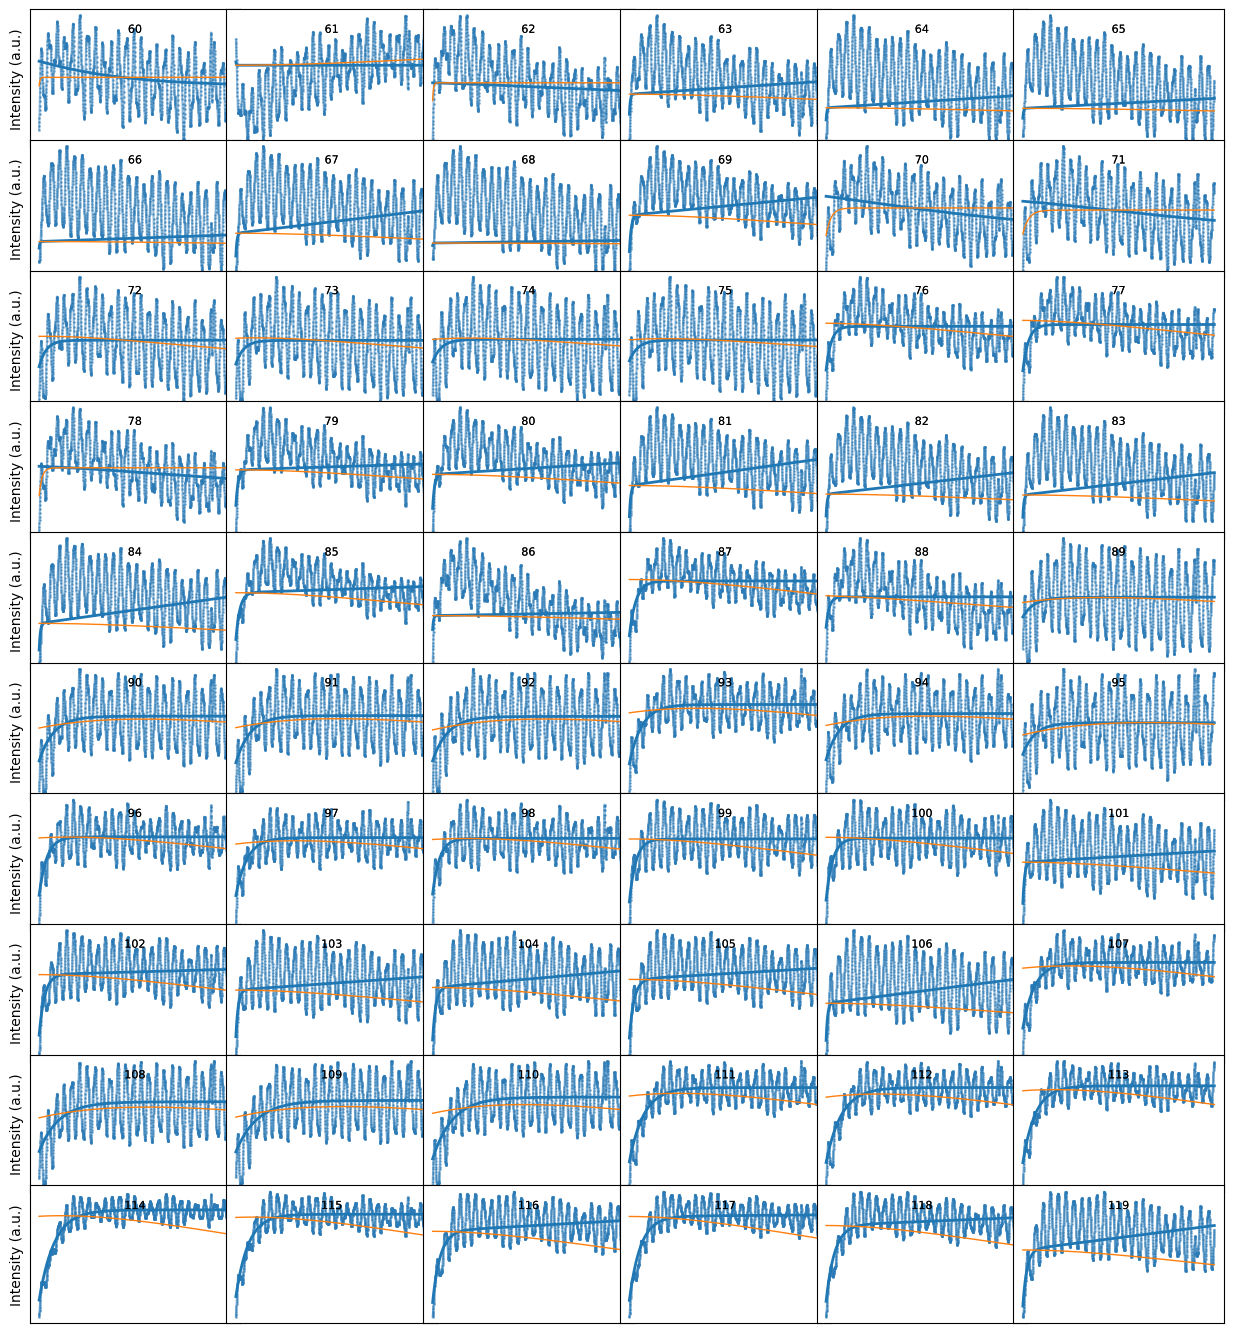

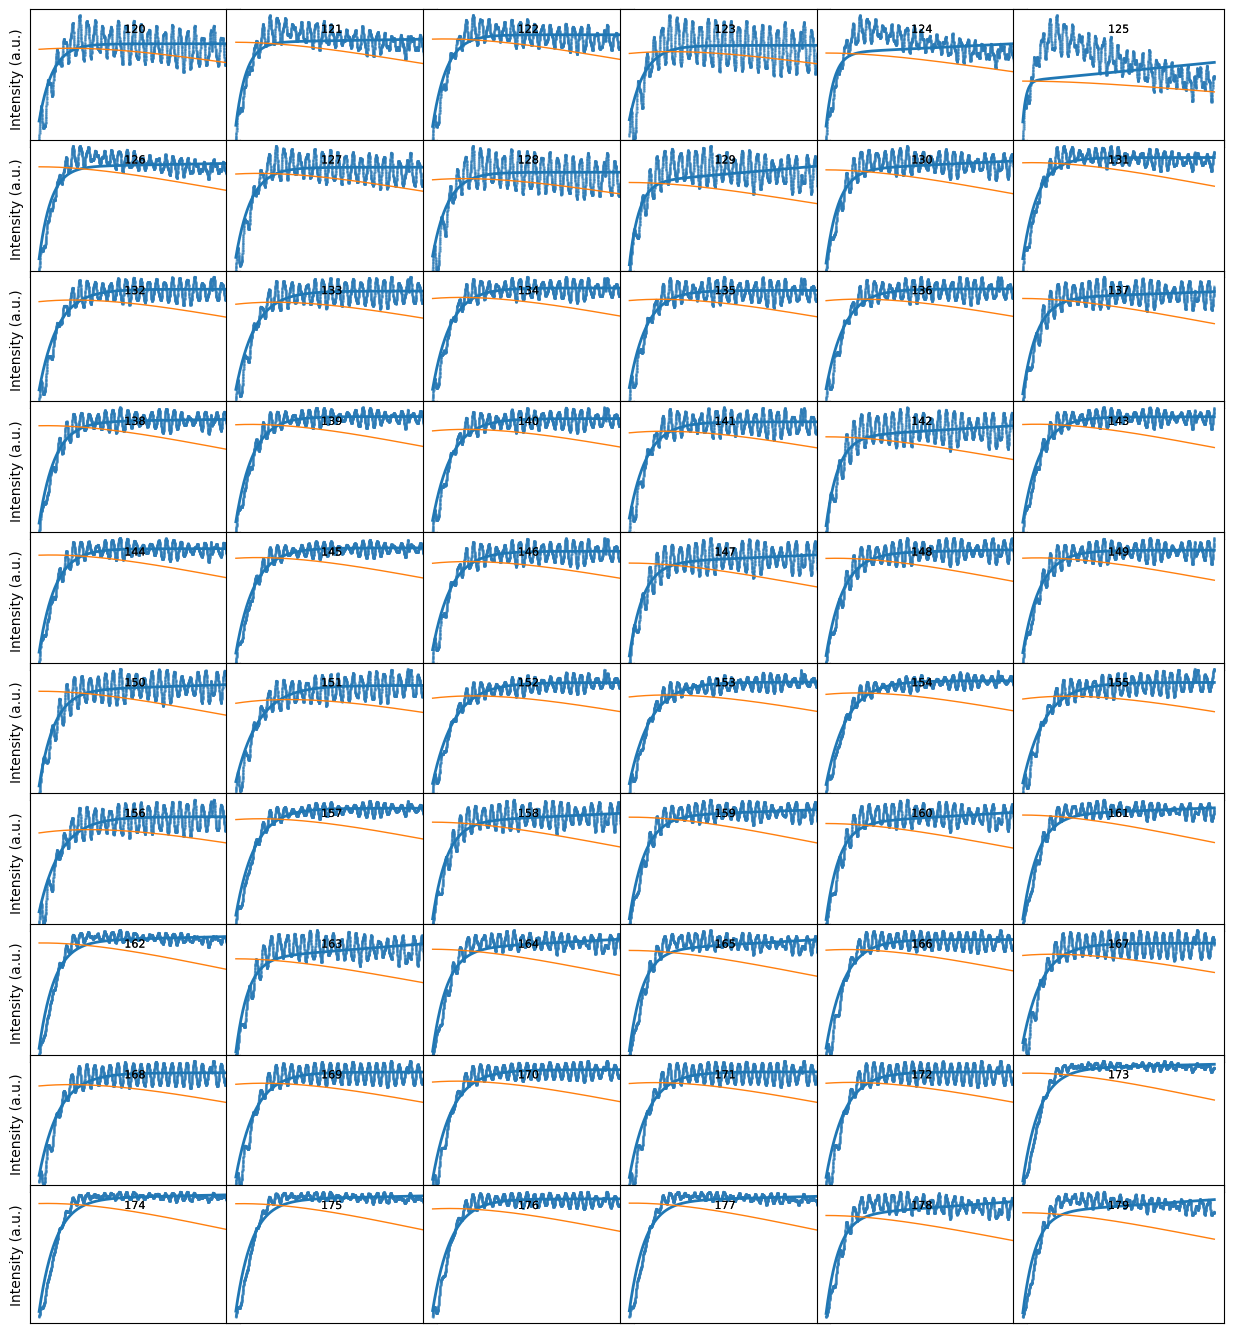

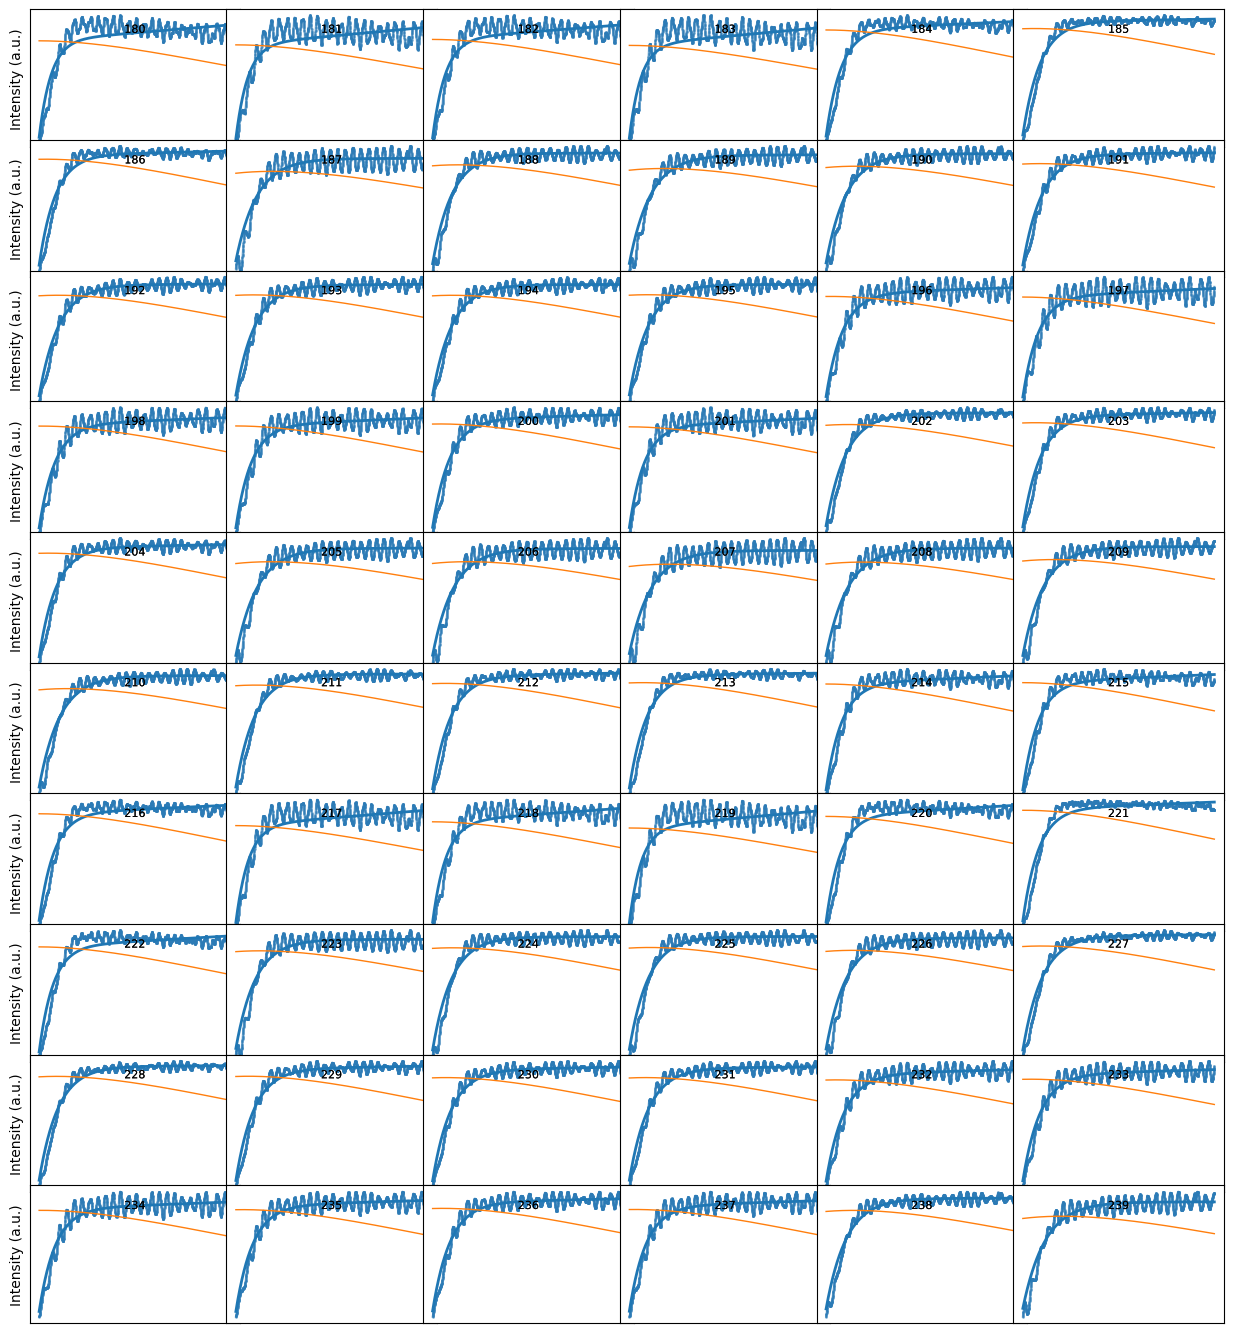

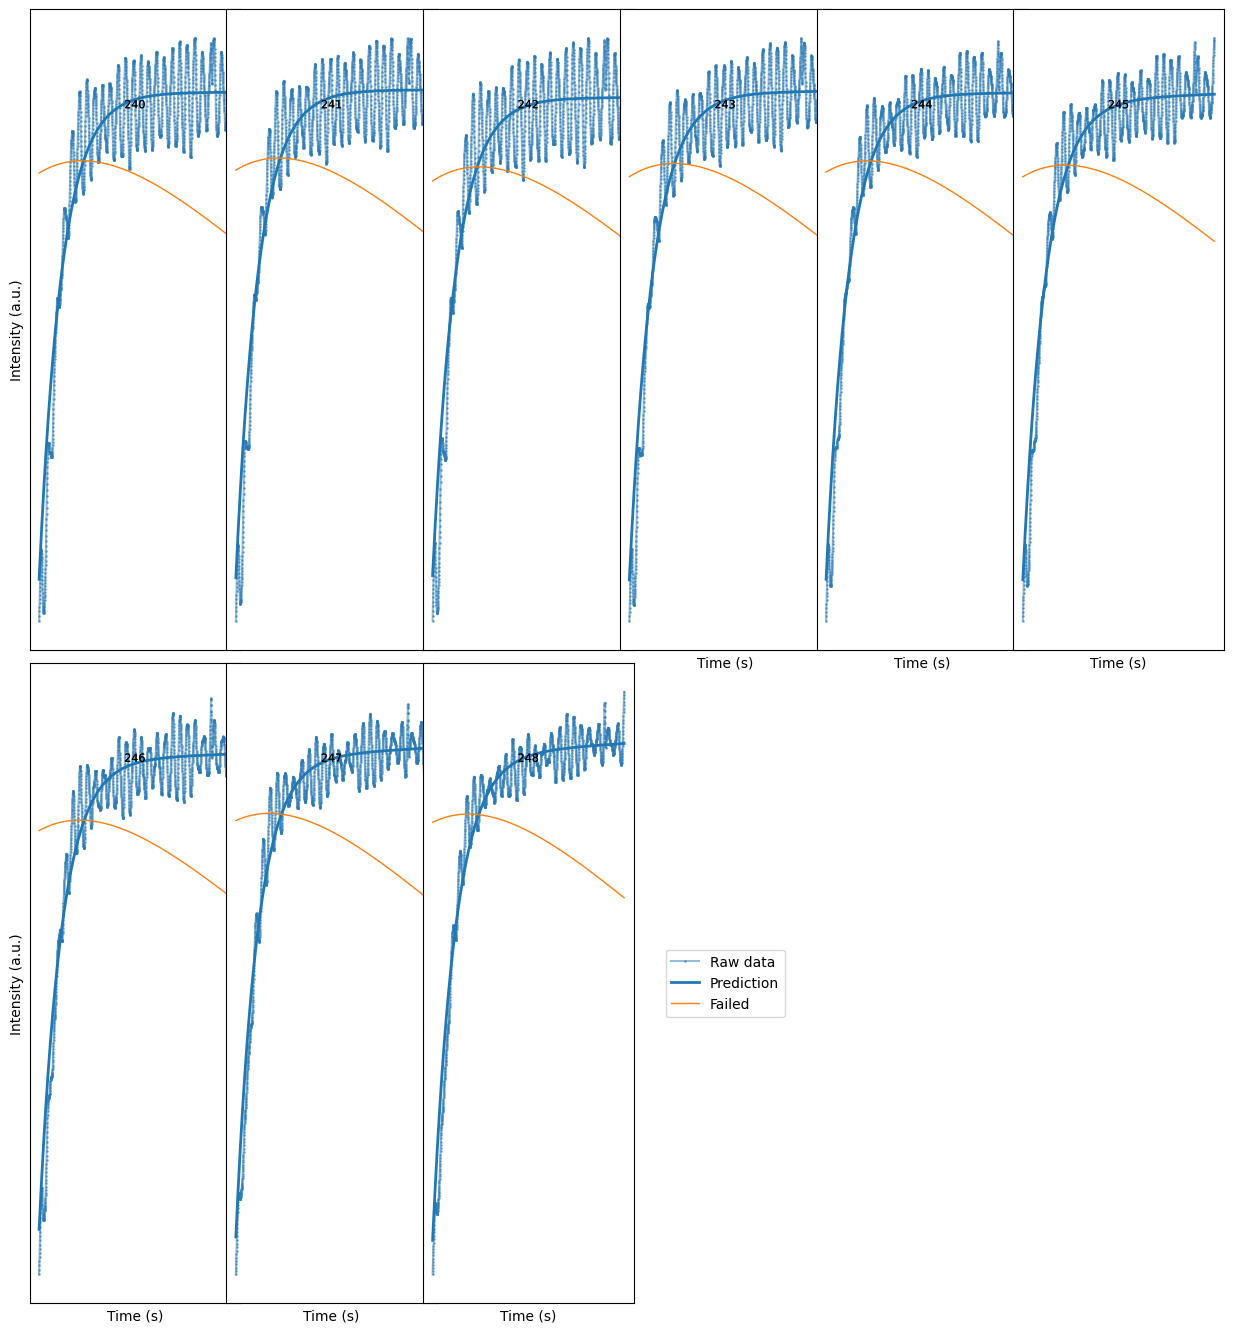

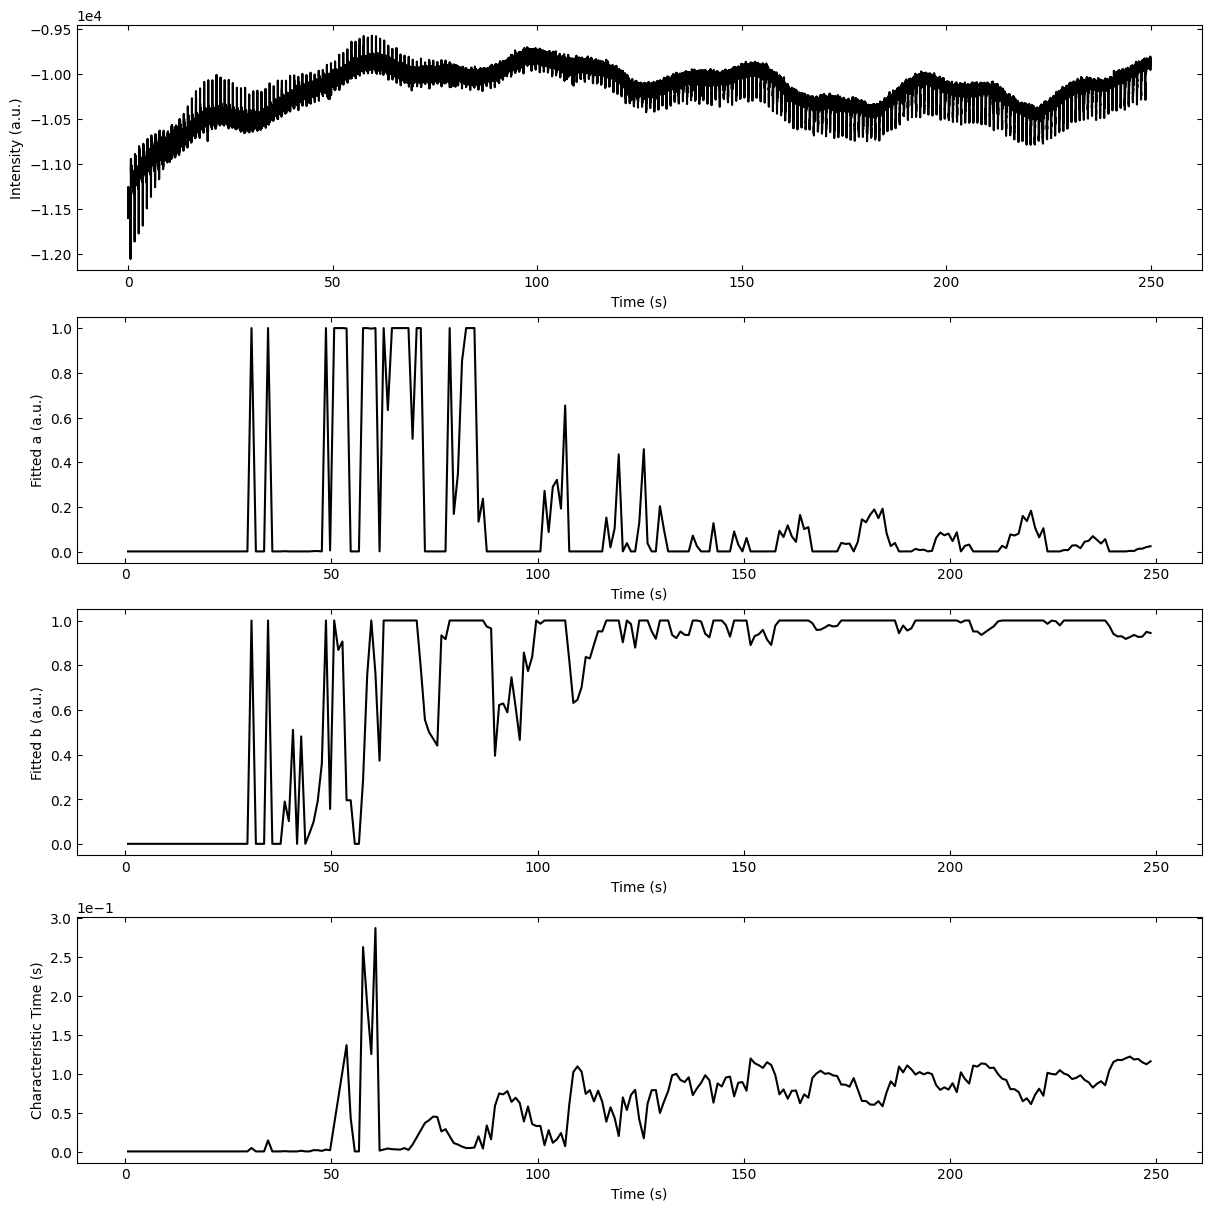

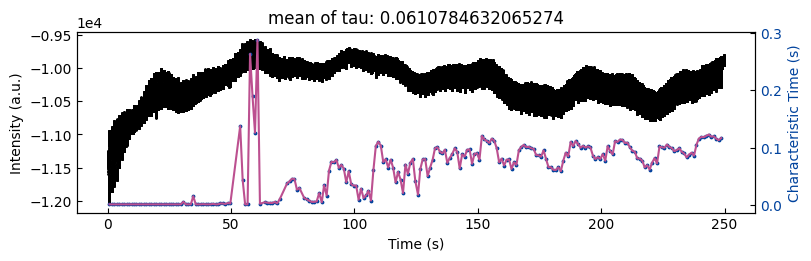

In [272]:
fit_settings={'step_size':101, 'prominence':10, 'savgol_window_order': (15, 3), 'pca_component': 3, 
              'I_diff': None, 'unify':False, 'bounds':[0.001, 1], 'p_init':[0.5, 0.4, 0.1]}
laser_freq = 1
camera_freq = 2000
viz_curves=True
viz_fittings=True
viz_ab=True

denoised_part_y = denoise_fft(sample_x, sample_y, cutoff_freq=20, denoise_order=1, sample_frequency=2000)
# denoised_part_y = denoise_median(part_x, part_y, kernel_size=51)
data = np.stack([sample_x, -denoised_part_y], 1)

parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, fit_settings, 
                                                           viz_curves, viz_fittings, viz_ab, n_std=3)